In [1]:
!wget -O test_x.npy https://www.dropbox.com/s/qfbaw6a18cthkg4/test_x.npy?dl=0
!wget -O train_x.npy https://www.dropbox.com/s/g35usly1qwt3iww/train_x.npy?dl=0
!wget -O train_y.csv https://www.dropbox.com/s/2sg1odr6tmbxgg7/train_y.csv?dl=0
!pip install pytorch_lightning
!pip install opencv-python

--2021-04-02 19:00:24--  https://www.dropbox.com/s/qfbaw6a18cthkg4/test_x.npy?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qfbaw6a18cthkg4/test_x.npy [following]
--2021-04-02 19:00:24--  https://www.dropbox.com/s/raw/qfbaw6a18cthkg4/test_x.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc790ef6e9fcfa2bf577aa798e79.dl.dropboxusercontent.com/cd/0/inline/BL0ulw3zsaHVShxNAGz6VXJh-vLSVUPtoRHmapX_g-GBOXlXA8GB9Z8cwP84nM7qJckm0tdykqkPIjrj0gbpm5DlIcE14Usrp2L9FnIQpmks5xtlONV4hb7P7tEOBzAE6K-FvnpgbzHDaxrj-44gskGE/file# [following]
--2021-04-02 19:00:25--  https://uc790ef6e9fcfa2bf577aa798e79.dl.dropboxusercontent.com/cd/0/inline/BL0ulw3zsaHVShxNAGz6VXJh-vLSVUPtoRHmapX_g-GBOXlXA8GB9Z8cwP84nM7qJckm0tdykqkPIjrj0gbpm5DlIcE

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
from tqdm import tqdm 

import torch as pt
import torch.nn as tnn
from torch.nn import functional as F
from dataset import DigitPictures
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from utils import *
from sklearn.metrics import accuracy_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [2]:
train_images = np.load("train_x.npy")
test_images = np.load("test_x.npy")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


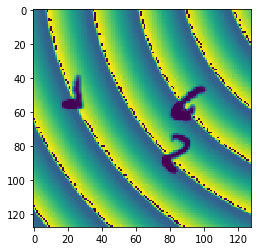

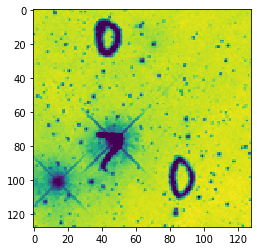

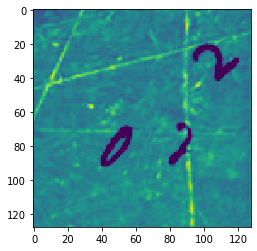

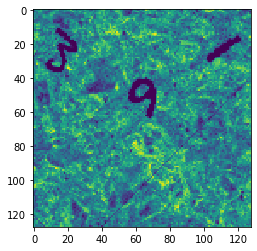

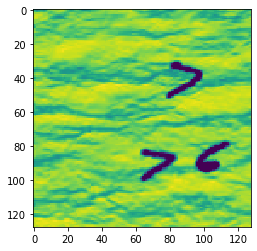

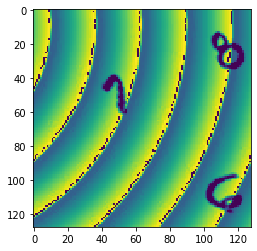

In [14]:
# displaying some pictures
def show_image(arr):
    two_d = (np.reshape(arr, (128, 128)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    plt.show()

for i in range(6):
  show_image(train_images[i]) 

In [4]:
with open('train_y.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    colnames = next(csv_reader)  # skip column names
    data = np.array([[int(row[0]), int(row[1])] for row in csv_reader if row])

# **Preparing the data**


### Let's instinciate the class and iterate through a couple of data samples

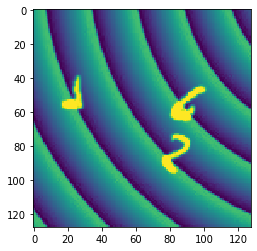

EXPECTED OUTPUT MAX :tensor(6)


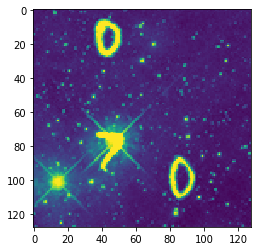

EXPECTED OUTPUT MAX :tensor(7)


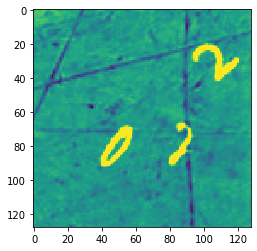

EXPECTED OUTPUT MAX :tensor(2)


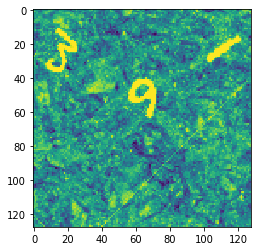

EXPECTED OUTPUT MAX :tensor(9)


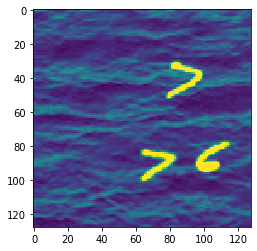

EXPECTED OUTPUT MAX :tensor(7)


In [ ]:
dataset = DigitPictures(data, train_images)

for i in range(5):
    sample_img = pt.squeeze(dataset[i][0])

    plt.imshow(sample_img, interpolation='nearest')
    plt.show()
    print('EXPECTED OUTPUT MAX :' + str(dataset[i][1]))

# Defining the model

In [58]:
class MNISTClassifier(pl.LightningModule):

    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.layer1 = vgg_conv_block([1,64], [64,64], [3,3], [1,1], 2, 2)
        self.layer2 = vgg_conv_block([64,128], [128,128], [3,3], [1,1], 2, 2)
        self.layer3 = vgg_conv_block([128,256,256], [256,256,256], [3,3,3], [1,1,1], 2, 2)
        self.layer4 = vgg_conv_block([256,256,256], [256,256,256], [3,3,3], [1,1,1], 2, 2)

        # FC layers
        self.layer5 = vgg_fc_layer(16384, 4096) # input for layer 5 is the dim of flattened form of output form layer 4
        self.layer6 = vgg_fc_layer(4096, 4096)

        # Final layer
        self.layer7 = tnn.Linear(4096, 10) # number of classes = 10 


    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        vgg16_features = self.layer4(x) # end of VGG blocks

        x = vgg16_features.view(x.size(0), -1) # Flatten the features
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        return loss

    def configure_optimizers(self):
        optimizer = pt.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

    # def backward(self, trainer, loss, optimizer, optimizer_idx):
    #     loss.backward()

## Training

In [ ]:
# Load data
train_loader = DataLoader(dataset, batch_size=32)

In [ ]:
# Train
model = MNISTClassifier()
trainer = pl.Trainer(gpus=1, auto_select_gpus=True, 
                     max_epochs=10)
trainer.fit(model, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layer1 | Sequential | 37.8 K
1 | layer2 | Sequential | 221 K 
2 | layer3 | Sequential | 1.5 M 
3 | layer4 | Sequential | 1.8 M 
4 | layer5 | Sequential | 67.1 M
5 | layer6 | Sequential | 16.8 M
6 | layer7 | Linear     | 41.0 K
--------------------------------------
87.5 M    Trainable params
0         Non-trainable params
87.5 M    Total params
349.840   Total estimated model params size (MB)


1

In [ ]:
# Save model
pt.save(model, "/content/drive/MyDrive/MNIST_model.pt")

In [ ]:
# model = MNISTClassifier.load_from_checkpoint("/content/lightning_logs/version_1/checkpoints/epoch=2-step=3749.ckpt")

In [ ]:
model = pt.load("/content/drive/MyDrive/MNIST_model.pt")
trainer = pl.Trainer(gpus=1, max_epochs=10)
trainer.fit(model, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layer1 | Sequential | 37.8 K
1 | layer2 | Sequential | 221 K 
2 | layer3 | Sequential | 1.5 M 
3 | layer4 | Sequential | 1.8 M 
4 | layer5 | Sequential | 67.1 M
5 | layer6 | Sequential | 16.8 M
6 | layer7 | Linear     | 41.0 K
--------------------------------------
87.5 M    Trainable params
0         Non-trainable params
87.5 M    Total params
349.840   Total estimated model params size (MB)


1

In [ ]:
pt.save(model, "/content/drive/MyDrive/MNIST_model_v2.pt")

In [ ]:
model_ = MNISTClassifier.load_from_checkpoint("/content/lightning_logs/version_1/checkpoints/epoch=9-step=12499.ckpt")

In [ ]:
pt.save(model_, "/content/drive/MyDrive/MNIST_model_v2.pt")

# Making inferences on test set

In [ ]:
# Without preprocessing (model v1 -- trained for 9 epochs -- BEST SUBMISSION)
model = pt.load("/content/drive/MyDrive/MNIST_model.pt")
inference(model, test_images, "/content/drive/MyDrive/MNIST_inferences.csv")

In [ ]:
# Without preprocessing (model v2 -- trained for 19 epochs)
model = pt.load("/content/drive/MyDrive/MNIST_model_v2.pt")
inference(model, test_images, "/content/drive/MyDrive/MNIST_inferences_v2.csv")

In [ ]:
# With preprocessing (model v2)
model = pt.load("/content/drive/MyDrive/MNIST_model_v2.pt")
inference_with_preprocessing(model, test_images, "/content/drive/MyDrive/MNIST_inferences_v3.csv")

# Calculating training set accuracy

In [ ]:
model_v1 = pt.load("/content/drive/MyDrive/MNIST_model.pt")
model_v2 = pt.load("/content/drive/MyDrive/MNIST_model_v2.pt")
inference(model_v1, train_images, "/content/MNIST_train_inference_v1.csv")
inference(model_v2, train_images, "/content/MNIST_train_inference_v2.csv")

In [ ]:
_, train_pred_v1 = np.genfromtxt('/content/MNIST_train_inference_v1.csv', delimiter=',', unpack=True, skip_header=1)
_, train_pred_v2 = np.genfromtxt('/content/MNIST_train_inference_v2.csv', delimiter=',', unpack=True, skip_header=1)
_, true_labels = np.genfromtxt('/content/train_y.csv', delimiter=',', unpack=True, skip_header=1)

In [ ]:
accuracy_score(true_labels, train_pred_v1)

In [ ]:
accuracy_score(true_labels, train_pred_v2)